In [58]:
##libraries and set up
import hddm
import pickle
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
# may be necessary to install ipyparalle depending on distribution 
#pip install ipyparallel
import ipyparallel
#load data:
fname  = '/home/jovyan/hddm/data/' + 'hddmdata_hlex_n58.csv' # very fast and very slow rts excluded, n = 58
data=hddm.load_csv(fname)
data.head()

#paths:
savepath='/home/jovyan/hddm/models/'; 
tracespath='/home/jovyan/hddm/models/traces/'


In [3]:
#run standard linear model to predict rt from stimulus strength z-scored within subjects (dd_Zws) 
# interaction of group
from statsmodels.formula.api import ols
X=data[['dd_Zws']]
y=data[['rt']]
model = ols("rt ~ dd_Zws*C(group)", data).fit()
# Print the summary
print(model.summary())

print("\nRetrieving manually the parameter estimates:")
print(model._results.params)

# n.b. control = 0; pre-HD=1; early-HD=2;
# 1: model shows significant effect for reduced RT with increasing HD (trend in figure 2)
# suggests to include non-decision time in HDDM 
# 2: there is a significant impact of dd_Zws: it reduces rt 
# (as expected: bigger dd_Zws are easier and lead to reduced rt)
# but this effect is attenuated in pre-hd and early-hd

# this suggests exploring further with HDDM would be fruitful 

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     86.01
Date:                Fri, 06 May 2022   Prob (F-statistic):           5.84e-89
Time:                        09:51:05   Log-Likelihood:                -4580.3
No. Observations:               10914   AIC:                             9173.
Df Residuals:                   10908   BIC:                             9216.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.3270 

## Fit HDDM regression models 

#### model comparison 1 to 5

#### always calculate only group level coefficients (not individual participants) 

In [119]:
dbpath=(tracespath + models[0] + '_s{nsamples}_b{nburn}_traces.db').format(nsamples = params[0], nburn = params[1])
dbpath

'/home/jovyan/hddm/models/traces/mreg1_s20000_b1000_traces.db'

In [108]:
# fit regression model 1 (simplest model), Z-score dd influenced drift directly, only
# calculate only group level coefficients

# set up parameters: 
mreg1 = hddm.models.HDDMRegressor(data, 'v ~ 0 + dd_Zws', 
                                  group_only_nodes=['v', 'a', 't'])
models=['mreg1', 'mreg2', 'mreg3', 'mreg4', 'mreg5']
params=[20000, 1000] # nsamples and nburn
dbpath=(tracespath + models[0] + '_s{nsamples}_b{nburn}_traces.db').format(nsamples = params[0], nburn = params[1])
# find a good starting point which helps with the convergence.
mreg1.find_starting_values()
#initiate model (N.B. time consuming process) and save
mreg1.sample(params[0], burn=params[1], dbname=dbpath, db='pickle'); 
mreg1.save(tracespath + models[0] + '_s{nsamples}_b{nburn}'.format(nsamples = params[0], nburn = params[1])) #save the model

#when finished generate and print  stats
stats = mreg1.gen_stats(); mreg1.print_stats()
#save stats as csv
mreg1.print_stats(fname=savepath + 'stats/' + models[0] + '_s{nsamples}_b{nburn}_stats.csv'.format(nsamples = params[0], nburn = params[1]))

#check model for convergence:
#1) plot posteriors
mreg1.plot_posteriors()
print('BPIC of {model} = {BPIC}'.format(model=models[0], BPIC=mreg1.mc.BPIC))

Adding these covariates:
['v_dd_Zws']
 [-----------------100%-----------------] 20001 of 20000 complete in 9528.1 sec-----------------49%                  ] 9831 of 20000 complete in 4704.2 sec[-----------------78%---------         ] 15712 of 20000 complete in 7495.4 secWARNING: Will not save custom link functions.


AttributeError: 'NoneType' object has no attribute 'format'

Adding these covariates:
['v_C(group)[0]', 'v_C(group)[1]', 'v_C(group)[2]', 'v_dd_Zws']
 [-----------------100%-----------------] 20001 of 20000 complete in 23178.7 secWARNING: Will not save custom link functions.
                   mean         std      2.5q       25q       50q       75q     97.5q       mc err
a               1.90321   0.0101949   1.88303   1.89642   1.90324   1.90999   1.92293  0.000110477
t                 0.497  0.00319038  0.490801  0.494814  0.497012  0.499166  0.503259  2.99981e-05
v_C(group)[0]  0.535418    0.015613  0.504788  0.524703  0.535433  0.545995  0.565954  0.000109167
v_C(group)[1]   0.61849   0.0201863  0.578862  0.605079  0.618477  0.632051  0.658316  0.000157425
v_C(group)[2]  0.668177    0.029915  0.608738  0.648231  0.668312  0.688577  0.726748  0.000227304
v_dd_Zws       0.237539   0.0112734   0.21551  0.229821  0.237464  0.245136  0.259687  8.79662e-05
DIC: 26571.196120
deviance: 26565.189217
pD: 6.006903
Plotting a
Plotting t
Plotting v_C(gro

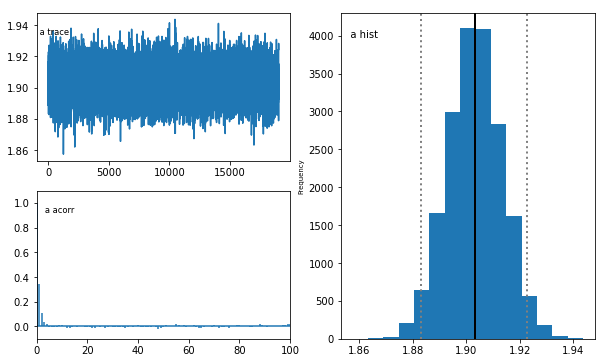

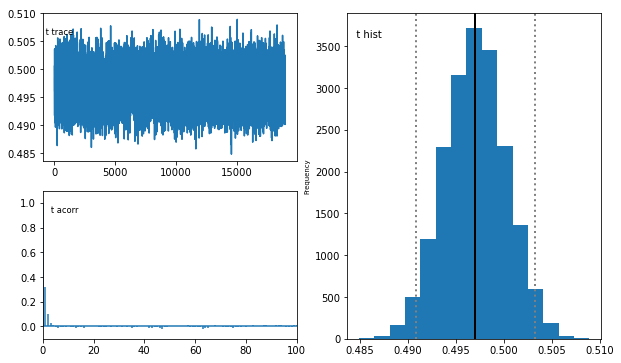

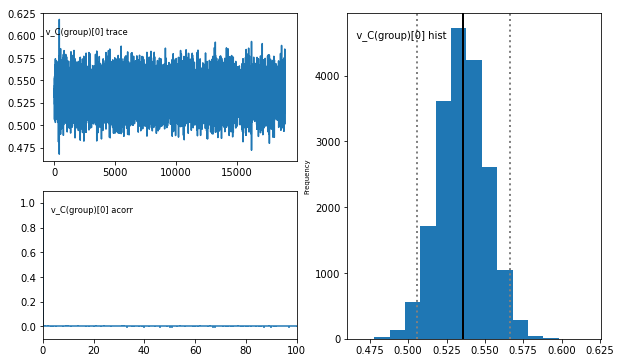

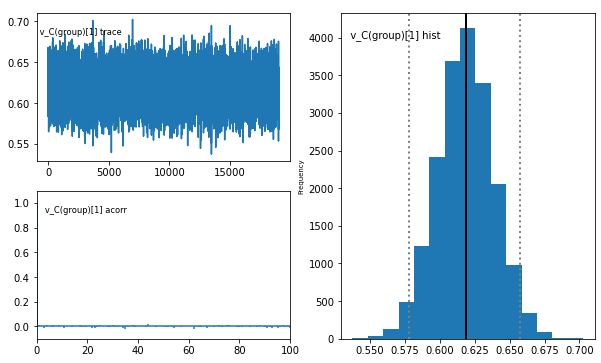

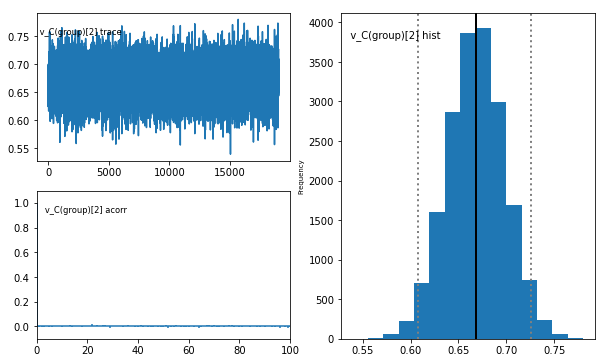

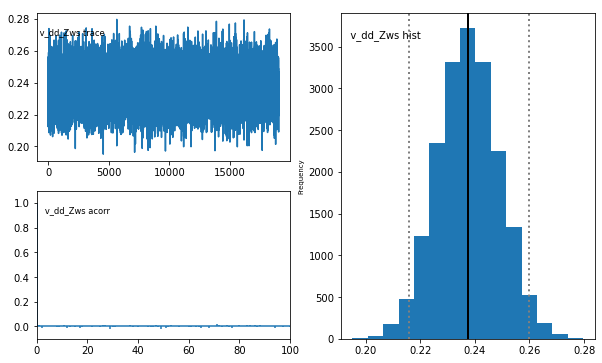

In [120]:
# fit regression model (2), dot_difference and group influenced drift rate directly, calculate group level coefficients only
mreg2 = hddm.models.HDDMRegressor(data, 'v ~ 0 + dd_Zws + C(group)', group_only_nodes=['v', 'a', 't'])

#specify save location (change to your chosen directory)
dbpath=(tracespath + models[1] + '_s{nsamples}_b{nburn}_traces.db'.format(nsamples = params[0], nburn = params[1]))

# find a good starting point which helps with the convergence.
mreg2.find_starting_values()
#initiate model
mreg2.sample(params[0], burn=params[1], dbname=dbpath, db='pickle')
mreg2.save(tracespath + models[1] + '_s{nsamples}_b{nburn}'.format(nsamples = params[0], nburn = params[1])) #save the model

#generate and print model stats
stats = mreg2.gen_stats(); mreg2.print_stats()
#save model stats as csv
mreg2.print_stats(fname=savepath + 'stats/' + models[1] + '_s{nsamples}_b{nburn}_stats.csv'.format(nsamples = params[0], nburn = params[1]))

#check model for convergence:
#1) plot posteriors
mreg2.plot_posteriors()
print('BPIC of {model} = {BPIC}'.format(model=models[1], BPIC=mreg2.mc.BPIC))

In [ ]:
# fit regression model (3): dot_difference and group influenced drift rate directly & dd*group interaction effect
mreg3 = hddm.models.HDDMRegressor(data, 'v ~ dd_Zws*C(group)',
                                  group_only_nodes=['v', 'a', 't'])

dbpath=(tracespath + models[2] + '_s{nsamples}_b{nburn}_traces.db'.format(nsamples = params[0], nburn = params[1]))

# find a good starting point which helps with the convergence.
mreg3.find_starting_values()

mreg3.sample(params[0], burn=params[1], dbname=dbpath, db='pickle')
#save the model
mreg3.save(tracespath + models[2] + '_s{nsamples}_b{nburn}'.format(nsamples = params[0], nburn = params[1])) #save the model
#print m_reg6 stats
stats = mreg3.gen_stats()
mreg3.print_stats()
mreg3.print_stats(fname=savepath + 'stats/' + models[2] + '_s{nsamples}_b{nburn}_stats.csv'.format(nsamples = params[0], nburn = params[1]))

mreg3.plot_posteriors()
print('BPIC of {model} = {BPIC}'.format(model=models[2], BPIC=mreg3.mc.BPIC))

Adding these covariates:
['v_Intercept', 'v_C(group)[T.1]', 'v_C(group)[T.2]', 'v_dd_Zws', 'v_dd_Zws:C(group)[T.1]', 'v_dd_Zws:C(group)[T.2]']
 [                  1%                  ] 333 of 20000 complete in 577.3 sec

Adding these covariates:
['v_C(group)[0]', 'v_C(group)[1]', 'v_C(group)[2]', 'v_dd_Zws', 'v_dd_Zws:C(group)[T.1]', 'v_dd_Zws:C(group)[T.2]']
Adding these covariates:
['a_C(group)[0]', 'a_C(group)[1]', 'a_C(group)[2]']
 [-----------------100%-----------------] 20001 of 20000 complete in 65926.4 secWARNING: Will not save custom link functions.
                               mean         std       2.5q        25q          50q         75q      97.5q       mc err
t                          0.498395  0.00288111   0.492809   0.496423     0.498375    0.500343   0.504115  2.96696e-05
v_C(group)[0]              0.561287   0.0159002   0.530026   0.550629     0.561212    0.572163   0.592315  0.000121945
v_C(group)[1]               0.61396   0.0209347   0.573374   0.600004     0.613838    0.627798   0.655686  0.000173191
v_C(group)[2]              0.595461     0.03018   0.536288   0.574803     0.595634    0.615931   0.654506  0.000239628
v_dd_Zws                   0.243392   0.0155619   0.212665   

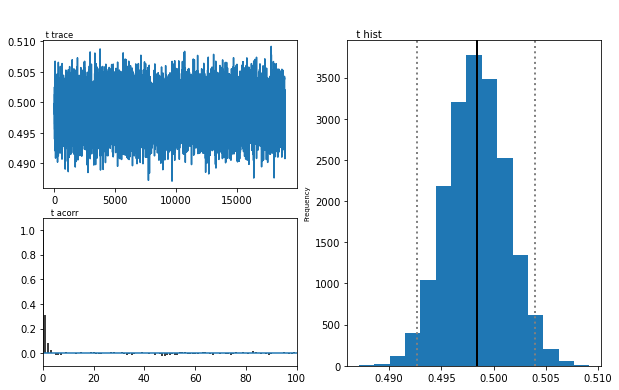

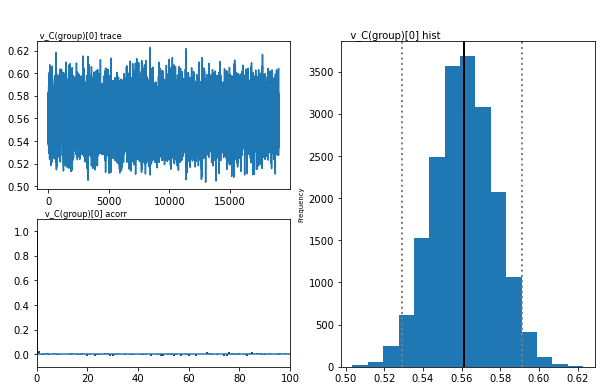

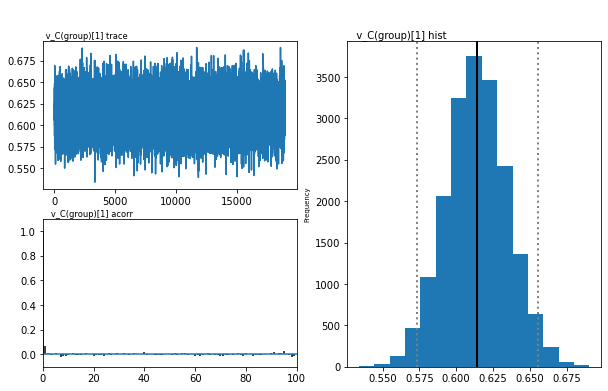

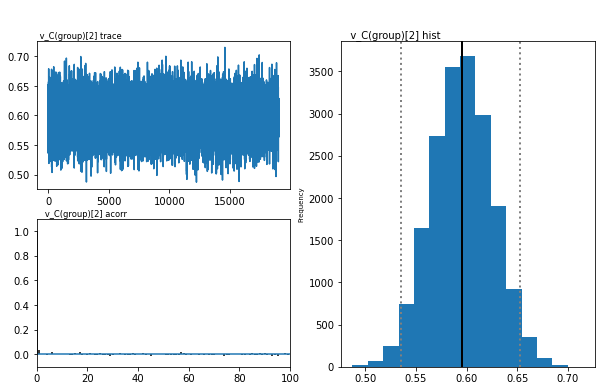

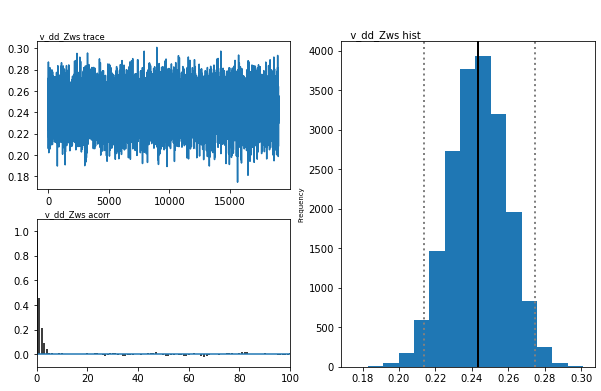

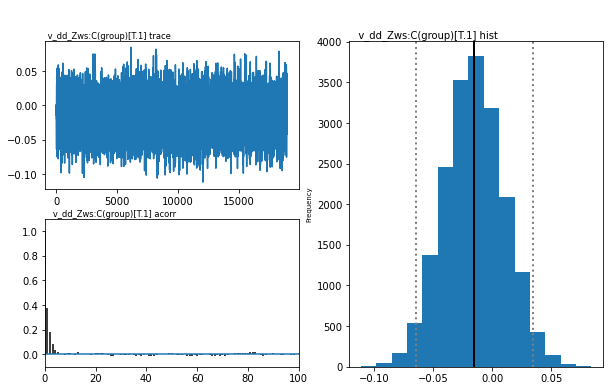

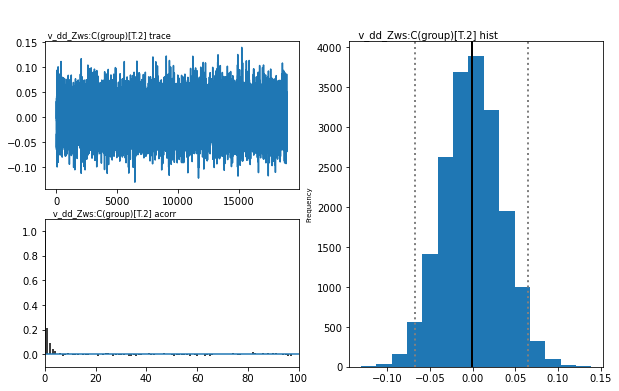

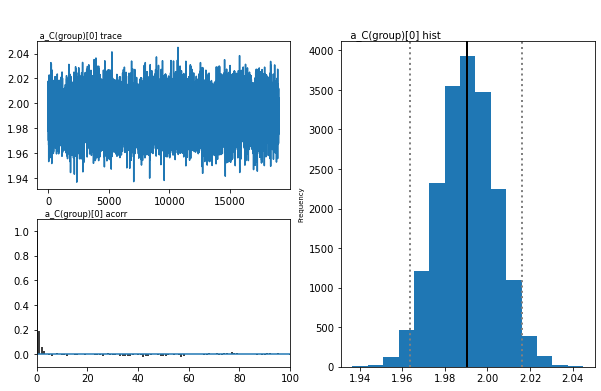

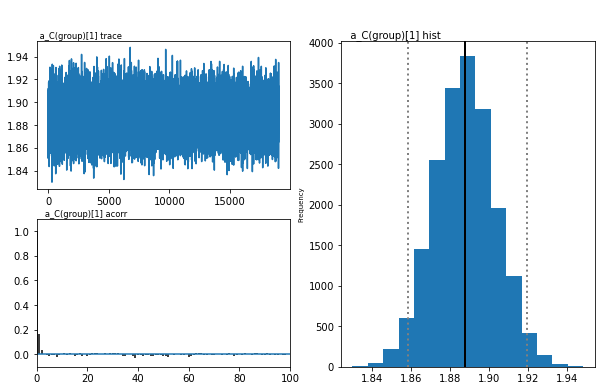

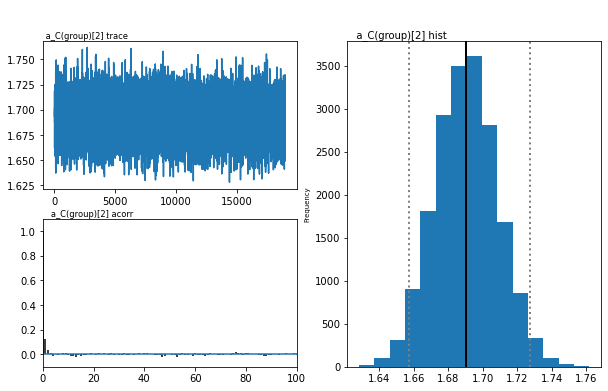

In [22]:
# fit regression model (4): dot_difference & group main + interaction effects, group effect on alpha
#group_only_nodes

mreg4 = hddm.models.HDDMRegressor(data,['v ~ 0 + dd_Zws*C(group)', 'a ~ 0 + C(group)'],
                                  group_only_nodes=['v', 't', 'a'])

dbpath=(tracespath + models[3] + '_s{nsamples}_b{nburn}_traces.db'.format(nsamples = params[0], nburn = params[1]))
# find a good starting point which helps with the convergence.
mreg4.find_starting_values()
#initial model with 2000 initial samples, burn=20 but did not converge very well (some autocorrelation)
mreg4.sample(params[0], burn=params[1], dbname=dbpath, db='pickle')
mreg4.save(tracespath + models[3] + '_s{nsamples}_b{nburn}'.format(nsamples = params[0], nburn = params[1]) #save the model

#print stats
stats = mreg4.gen_stats()
mreg4.print_stats()
mreg4.plot_posteriors()
mreg4.print_stats(fname=savepath + 'stats/' + models[3] + '_s{nsamples}_b{nburn}_stats.csv'.format(nsamples = params[0], nburn = params[1])
#also display BPIC (stricter version of DIC with greater penalty: DIC+(2*pD))
print('BPIC of {model} = {BPIC}'.format(model=models[3], BPIC=mreg4.mc.BPIC))

Adding these covariates:
['v_C(group)[0]', 'v_C(group)[1]', 'v_C(group)[2]', 'v_dd_Zws', 'v_dd_Zws:C(group)[T.1]', 'v_dd_Zws:C(group)[T.2]']
Adding these covariates:
['a_C(group)[0]', 'a_C(group)[1]', 'a_C(group)[2]']
Adding these covariates:
['t_C(group)[0]', 't_C(group)[1]', 't_C(group)[2]']
 [-----------------100%-----------------] 20001 of 20000 complete in 98293.7 secWARNING: Will not save custom link functions.
                             mean         std        2.5q        25q        50q        75q      97.5q       mc err
v_C(group)[0]             2.80021   0.0364727     2.72886    2.77543    2.80058    2.82532    2.86987  0.000876988
v_C(group)[1]            0.614817   0.0205371    0.574463   0.600833   0.615042    0.62885    0.65487  0.000161332
v_C(group)[2]            0.585245   0.0285098    0.529552   0.566042   0.585133   0.604396   0.641025  0.000203836
v_dd_Zws                0.0405793   0.0145438   0.0118124  0.0309463  0.0406441  0.0503986  0.0691218  0.000172289
v_dd

32497.134069855834

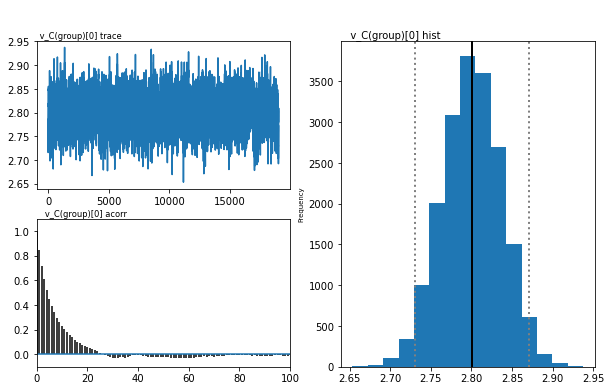

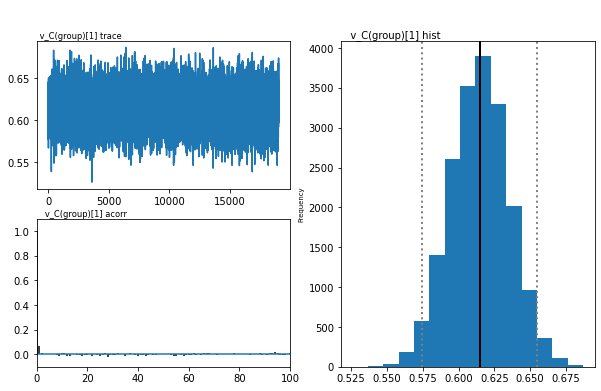

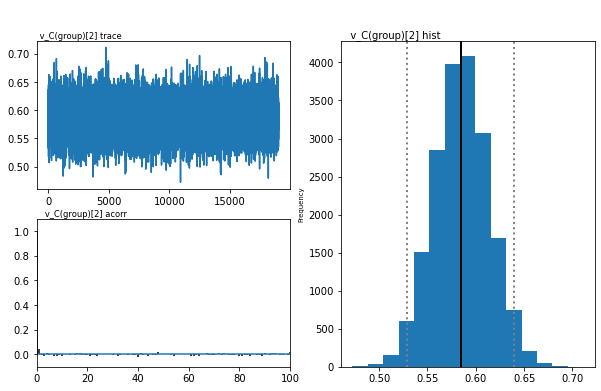

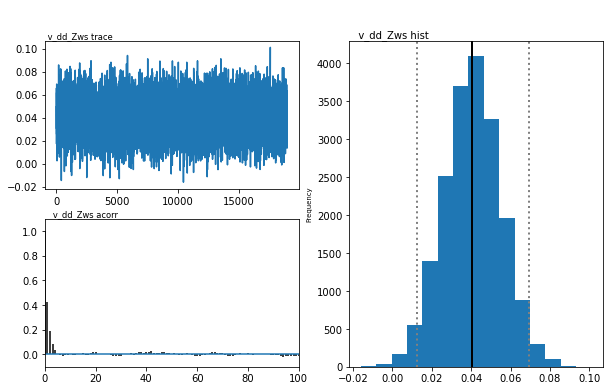

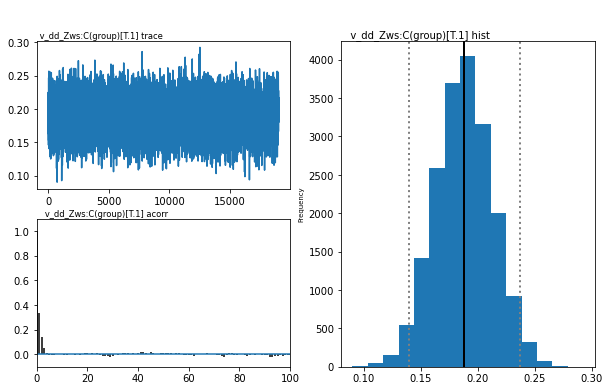

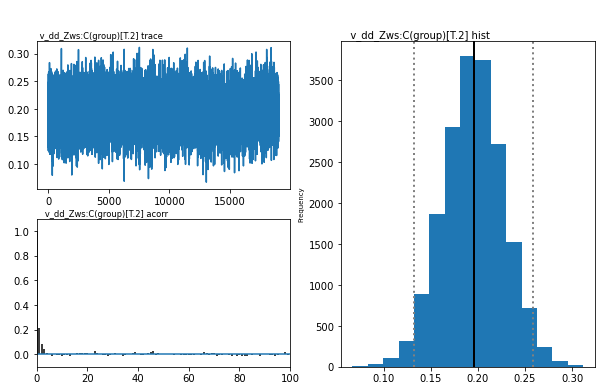

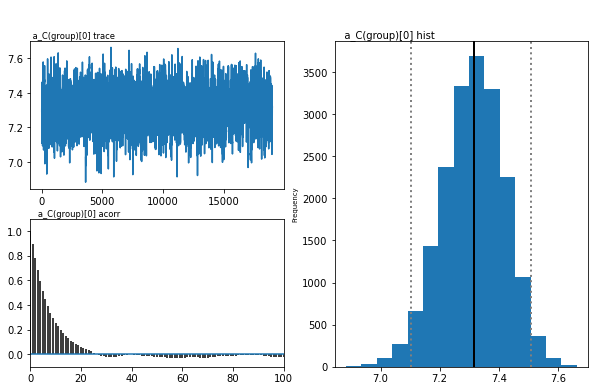

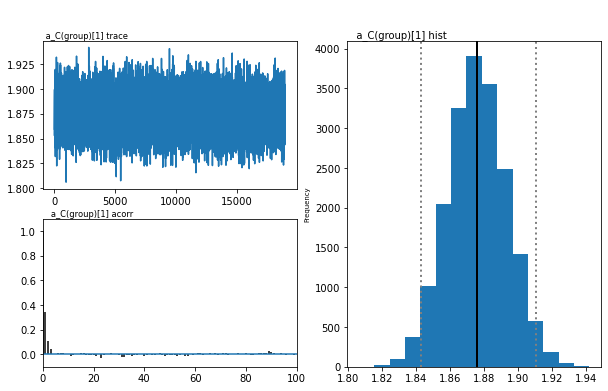

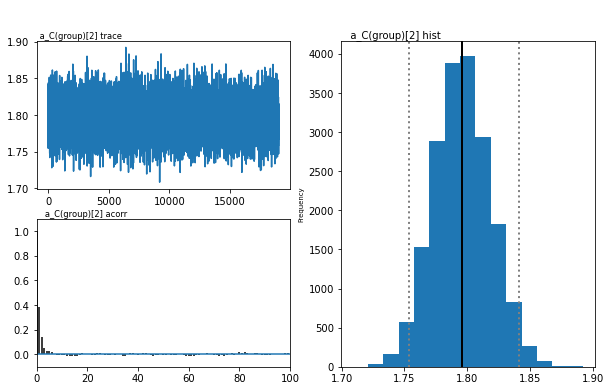

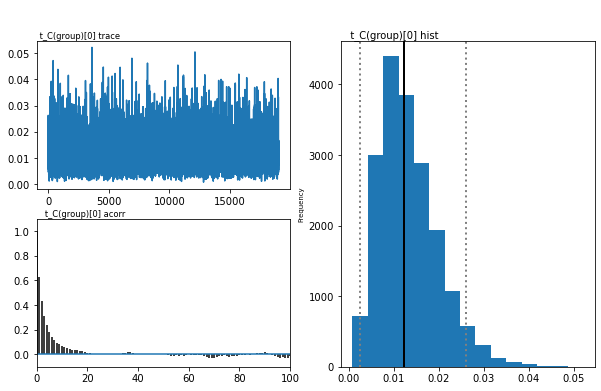

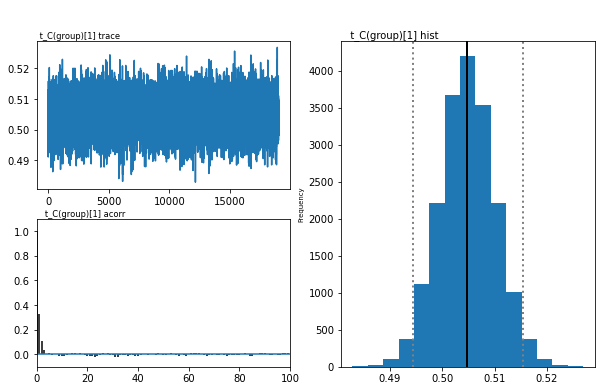

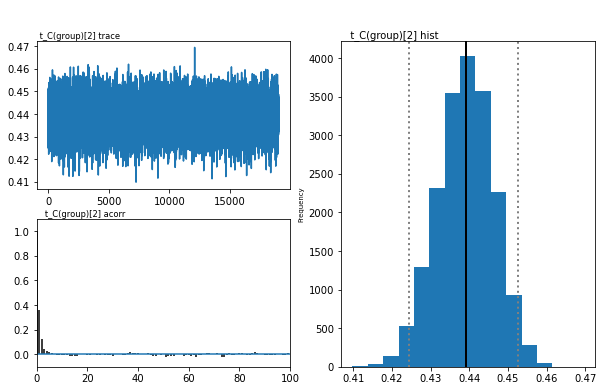

In [50]:
# fit regression model (5), dd & group main + interaction effects, group effect on alpha & group effect on tau
#not depends on
#group only nodes
#remove intercept with +0 so only effects on v are DD_Zws and group, and a and t only group
mreg5 = hddm.models.HDDMRegressor(data, ['v ~ 0 + dd_Zws*C(group)', 'a ~ 0 + C(group)', 't ~ 0 + C(group)'],
                                  group_only_nodes=['v', 't', 'a'])

dbpath=(tracespath + models[4] + '_s{nsamples}_b{nburn}_traces.db'.format(nsamples = params[0], nburn = params[1]))
# find a good starting point which helps with the convergence.
mreg5.find_starting_values()
#initiate sampling:
mreg5.sample(params[0], burn=params[1], dbname=dbpath, db='pickle')
#save model
mreg5.save(tracespath + models[4] + '_s{nsamples}_b{nburn}'.format(nsamples = params[0], nburn = params[1])) #save the model

#print m_reg6 stats
stats = mreg5.gen_stats()
mreg5.print_stats()
mreg5.print_stats(fname=savepath + 'stats/' + models[4] + '_s{nsamples}_b{nburn}_stats.csv'.format(nsamples = params[0], nburn = params[1]))

#check posteriors for convergence:
mreg5.plot_posteriors()
#also display BPIC (stricter version of DIC with greater penalty: DIC+(2*pD))
print('BPIC of {model} = {BPIC}'.format(model=models[4], BPIC=mreg5.mc.BPIC))

## Fit models in parallel: n.b. this will take several hours 

#### function run_model contains model specification, name and dir parameters
#### uses ipyparallel to run 4 models on 4 CPUs 

In [77]:
%matplotlib inline

# Preparation 
import os, time, csv, datetime
import kabuki, hddm
from kabuki.analyze import gelman_rubin

from datetime import date

import random
import pandas as pd
import matplotlib.pyplot as plt

# define a function to run model in parallel: set parameters

def run_model(id):
    params=[20000, 1000] # nsamples and nburn
    import hddm
    print('running model%i'%id);
    
    model_prefix = 'mreg4_s{nsamples}_b{nburn}'.format(nsamples=params[0], nburn=params[1])
    print('running models %i'%id, 'of: ', model_prefix)

    #  use absolute directory in docker.
    dbname = '/home/jovyan/hddm/models/parallel/' + model_prefix + '_chain_%i.db'%id # define the database name, which uses pickle format
    mname  = '/home/jovyan/hddm/models/parallel/' + model_prefix + '_chain_%i'%id    # model name 
    fname  = '/home/jovyan/hddm/data/' + 'hddmdata_hlex_n58.csv'# data file  
    data = hddm.load_csv(fname) # load data 

    m = hddm.HDDMRegressor(data,['v ~ 0 + dd_Zws*C(group)', 'a ~ 0 + C(group)'],
                                  group_only_nodes=['v', 't', 'a']) # model specification 
    m.find_starting_values()
    m.sample(params[0], burn=params[1], dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

import sys
import time
from IPython.display import clear_output
# define progress time function 
def wait_watching_stdout(ar, dt=30):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output, you can make is shorter or longer.
    """

    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

In [67]:
# start a cluster:
n_CPU=4 # number of CPUs to use 

import ipyparallel as ipp
cluster = ipp.Cluster(n=n_CPU)
cluster.start_cluster_sync()

# and  cluster is running 
rc = cluster.connect_client_sync()
rc.wait_for_engines(4); rc.ids

Using existing profile dir: '/home/jovyan/.ipython/profile_default'
Starting 4 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


<Cluster(cluster_id='1651837576-j367', profile='default', controller=<running>, engine_sets=['1651837577'])>

In [78]:
## run model estimation: 

start_time = time.time()  # the start time of the processing
v = rc[:] # use all engines
jobs = v.map(run_model, range(n_CPU))
wait_watching_stdout(jobs)
models = jobs.get()
m1_time = time.time() 
print("\nRunning 4 chains used: %f seconds." % (m1_time - start_time)) # every 30 seconds 

------------------------------
54614.871s elapsed

running model0
running models 0 for for exp mreg4_s20000_b1000
Adding these covariates:
['v_C(group)[0]', 'v_C(group)[1]', 'v_C(group)[2]', 'v_dd_Zws', 'v_dd_Zws:C(group)[T.1]', 'v_dd_Zws:C(group)[T.2]']
Adding these covariates:
['a_C(group)[0]', 'a_C(group)[1]', 'a_C(group)[2]']
 [-----------------100%-----------------] 20001 of 20000 complete in 54184.9 secWARNING: Will not save custom link functions.

running model1
running models 1 for for exp mreg4_s20000_b1000
Adding these covariates:
['v_C(group)[0]', 'v_C(group)[1]', 'v_C(group)[2]', 'v_dd_Zws', 'v_dd_Zws:C(group)[T.1]', 'v_dd_Zws:C(group)[T.2]']
Adding these covariates:
['a_C(group)[0]', 'a_C(group)[1]', 'a_C(group)[2]']
 [-----------------100%-----------------] 20000 of 20000 complete in 54606.0 sec
running model2
running models 2 for for exp mreg4_s20000_b1000
Adding these covariates:
['v_C(group)[0]', 'v_C(group)[1]', 'v_C(group)[2]', 'v_dd_Zws', 'v_dd_Zws:C(group)[T.1]', '

Rhat range 0.99998 - 1.00015
Combining models...
Plotting t
Plotting v_C(group)[0]
Plotting v_C(group)[1]
Plotting v_C(group)[2]
Plotting v_dd_Zws
Plotting v_dd_Zws:C(group)[T.1]
Plotting v_dd_Zws:C(group)[T.2]
Plotting a_C(group)[0]
Plotting a_C(group)[1]
Plotting a_C(group)[2]
                               mean         std       2.5q        25q          50q         75q      97.5q       mc err
t                          0.498445  0.00288224   0.492725   0.496537     0.498452    0.500408   0.504054  1.57377e-05
v_C(group)[0]              0.561421   0.0158789   0.530214   0.550751     0.561368    0.572176   0.592562  6.20395e-05
v_C(group)[1]              0.613888   0.0206278   0.573626   0.599952     0.613895    0.627764   0.654486  8.98817e-05
v_C(group)[2]               0.59509   0.0300763   0.536373   0.574678     0.595185    0.615459   0.654188  0.000112818
v_dd_Zws                   0.243275   0.0155358   0.212873    0.23279     0.243277    0.253721   0.273706  8.94372e-05
v_dd_Z

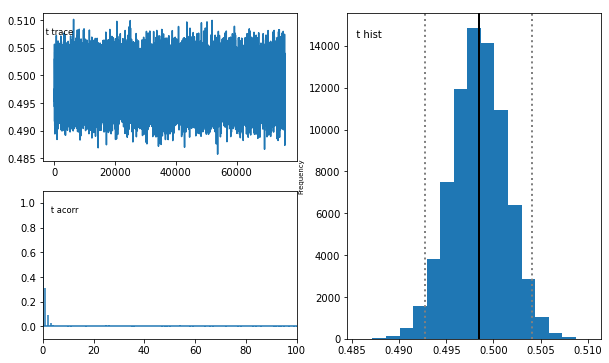

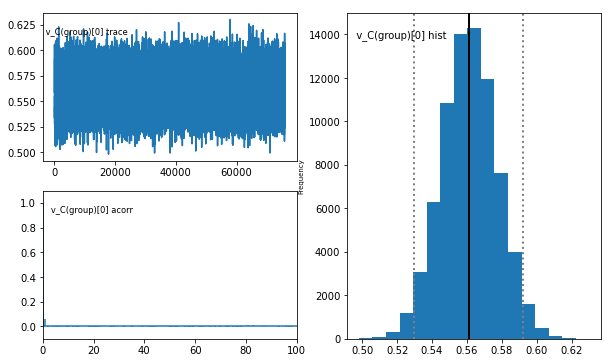

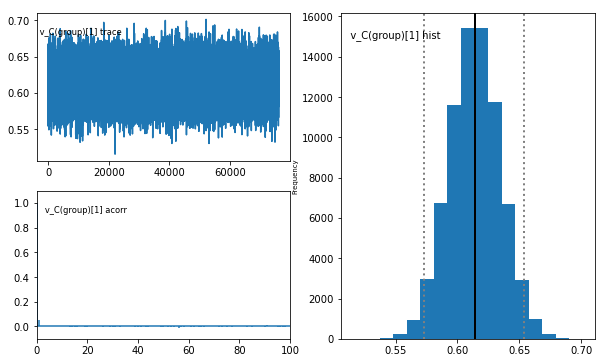

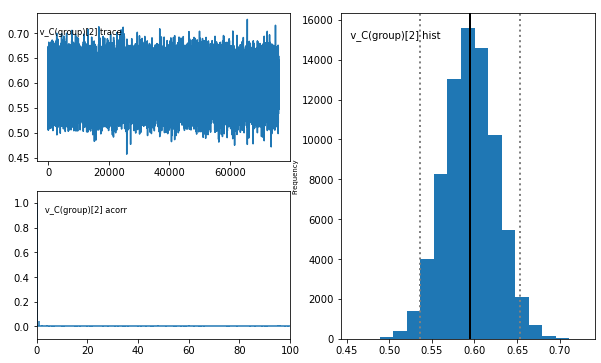

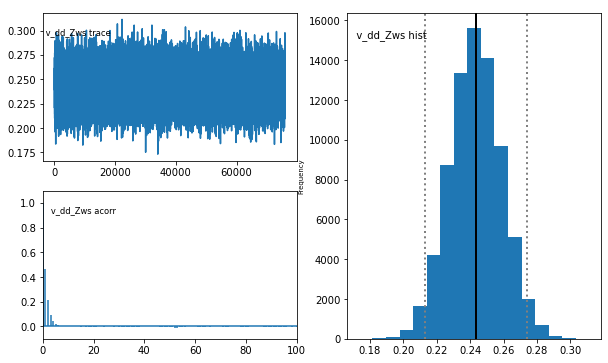

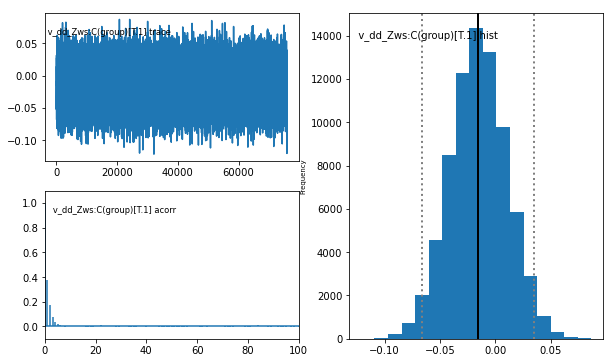

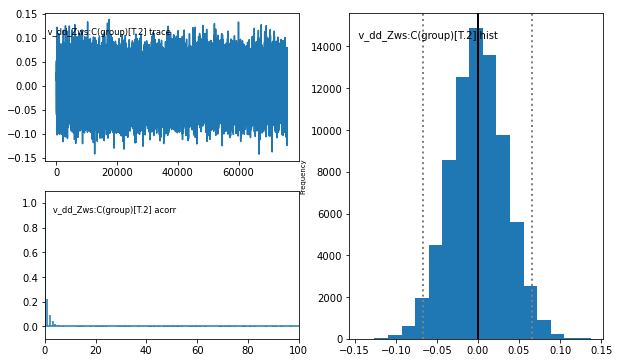

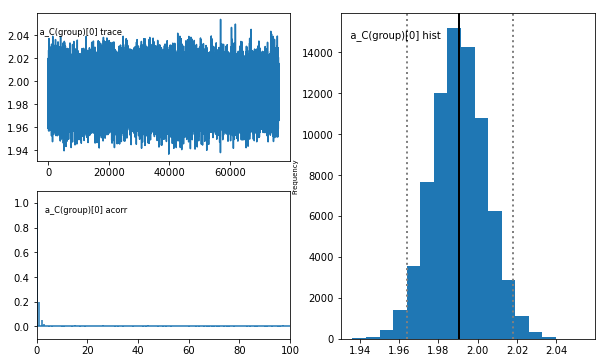

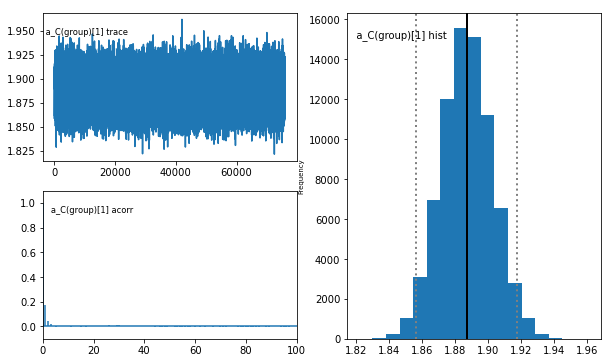

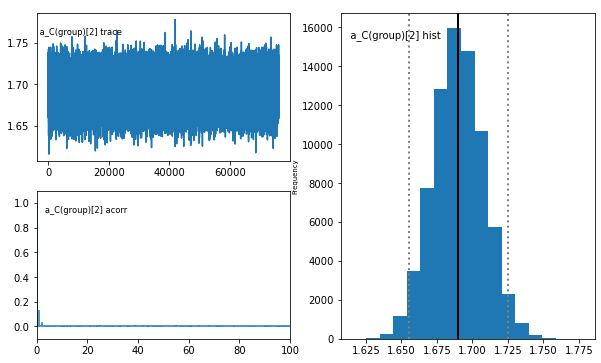

In [107]:
#get rhat which is dictionary
rhat=gelman_rubin(models)

#create a dataframe:
df = pd.DataFrame(list(rhat.items()),columns = ['parameter', 'rhat']) 
#get mean and summary stats:
rhatM=round(df.rhat.mean(), 5)
rhatMax=round(df.rhat.max(), 5)
rhatMin=round(df.rhat.min(), 5)

print('Rhat range {rhatmin} - {rhatmax}'.format(rhatmin=rhatMin, rhatmax=rhatMax))

# save rhat df to csv
df.to_csv('/home/jovyan/hddm/models/parallel/stats/rhat.csv')
print('Combining models...')

# Create a new model that has all traces concatenated
# of individual models
combined_model = kabuki.utils.concat_models(models)
combined_model.plot_posteriors()
# generate stats
stats= combined_model.gen_stats()
combined_model.print_stats()
#optionally save combined model for later 
# e.g., combined_model.save('combined_m')

In [105]:
# get statistics from each model:
statsdf=[];
for i in range(len(models)):
    statsdf.append(models[i].gen_stats())
    models[i].print_stats()
#append the combined model on:
statsdf.append(combined_model.gen_stats())
    
# concatenate the dataframes together:
result = pd.concat(statsdf, keys=["Model 1", "Model 2", "Model 3", "Model 4", "Combined"], axis=1)
#rename rows:
res=result.rename(index={"t": "Non-decision time (t)",
                     "v_C(group)[0]": "v Control",
                     "v_C(group)[1]": "v Pre-HD",
                     "v_C(group)[2]": "v Early-HD",
                     "v_dd_Zws": "v Control*stimulus",
                     "v_dd_Zws:C(group)[T.1]": "v Pre-HD*stimulus",
                     "v_dd_Zws:C(group)[T.2]": "v Early-HD*stimulus",
                     "a_C(group)[0]": "a Control",
                     "a_C(group)[1]": "a Pre-HD",
                     "a_C(group)[2]": "a Early-HD",
                    }).style.format("{:.2f}")

#save statistics to csv: 
res.data.to_csv('/home/jovyan/hddm/models/parallel/stats/res.csv')

                               mean         std       2.5q        25q          50q         75q      97.5q       mc err
t                          0.498451  0.00289685   0.492673   0.496538     0.498461    0.500449   0.504114   2.7408e-05
v_C(group)[0]              0.561237   0.0159389   0.529945   0.550537     0.561009    0.572078   0.592297  0.000121038
v_C(group)[1]               0.61385   0.0206338   0.573749   0.599763     0.613865    0.627722   0.654795  0.000150805
v_C(group)[2]              0.595386   0.0301126   0.535772   0.575234     0.595677    0.615631   0.654178  0.000244929
v_dd_Zws                   0.242907   0.0156378   0.212333   0.232341     0.242895    0.253407   0.273948  0.000192327
v_dd_Zws:C(group)[T.1]   -0.0146747   0.0257247  -0.065411 -0.0321137   -0.0147607  0.00264008  0.0353531  0.000313981
v_dd_Zws:C(group)[T.2]  0.000796173   0.0339612 -0.0658231 -0.0218202  0.000663977    0.023644  0.0671479  0.000332374
a_C(group)[0]               1.99048      0.0137 

# Load models estimated in our analysis 

#### reported in published manuscript: https://neurologyopen.bmj.com/content/4/1/e000268 

                               mean         std       2.5q        25q          50q         75q      97.5q       mc err
t                           0.49848  0.00294595   0.492695   0.496508     0.498499    0.500466   0.504213  2.83982e-05
v_C(group)[0]              0.561614    0.016056   0.530203   0.550718     0.561553    0.572391   0.593053  0.000129239
v_C(group)[1]              0.613964   0.0207225    0.57302   0.600166      0.61391    0.627772   0.654432  0.000148264
v_C(group)[2]              0.594976   0.0302464    0.53663   0.574628     0.594457    0.615267   0.654677  0.000218256
v_dd_Zws                   0.243293   0.0154373   0.212582   0.232912     0.243436    0.253745   0.273143  0.000180396
v_dd_Zws:C(group)[T.1]   -0.0151582   0.0256052 -0.0648472 -0.0324837   -0.0152034  0.00202566  0.0357497  0.000285465
v_dd_Zws:C(group)[T.2]  0.000104136   0.0331753 -0.0638445 -0.0226752 -6.67371e-05   0.0223618  0.0658526  0.000297996
a_C(group)[0]               1.99044   0.0137558 

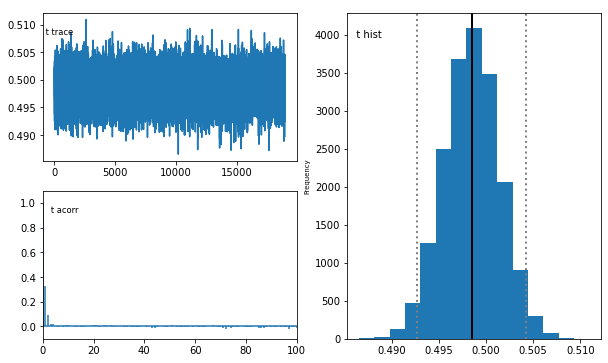

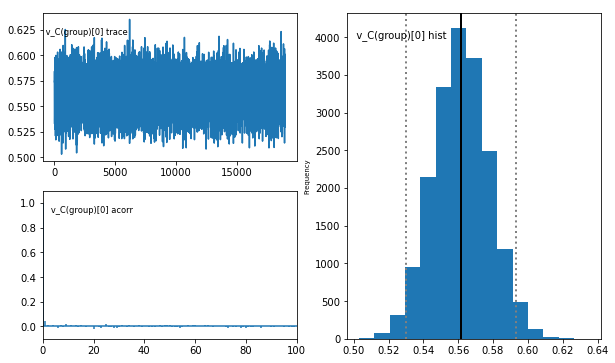

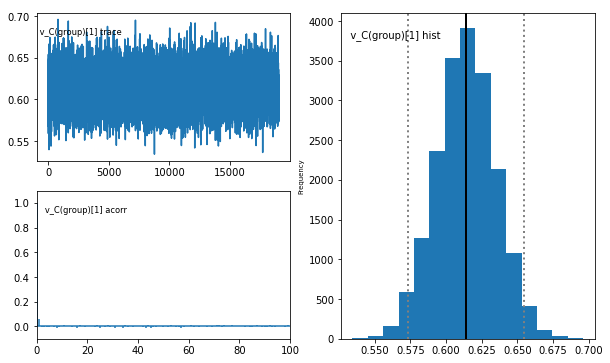

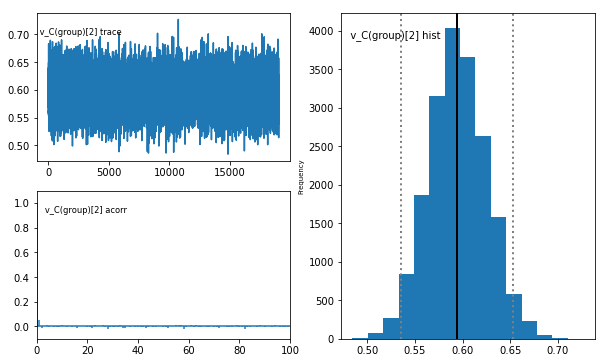

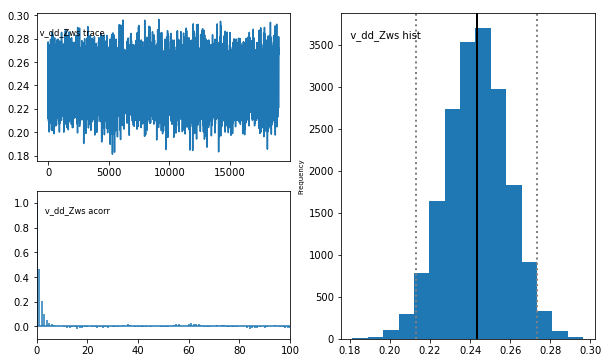

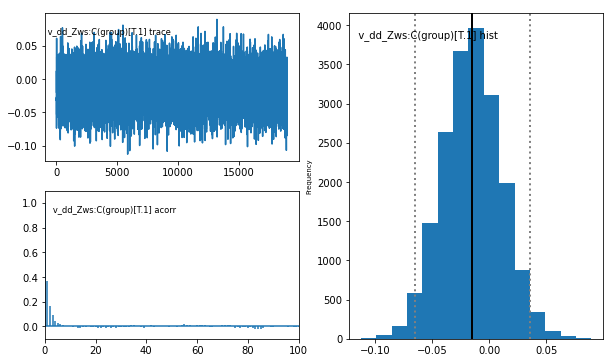

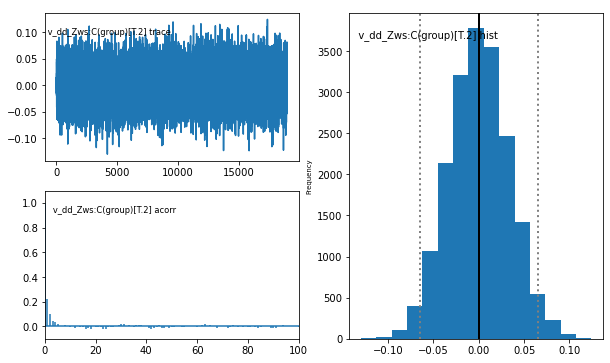

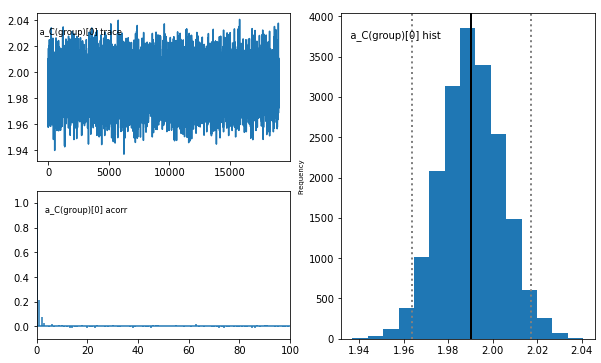

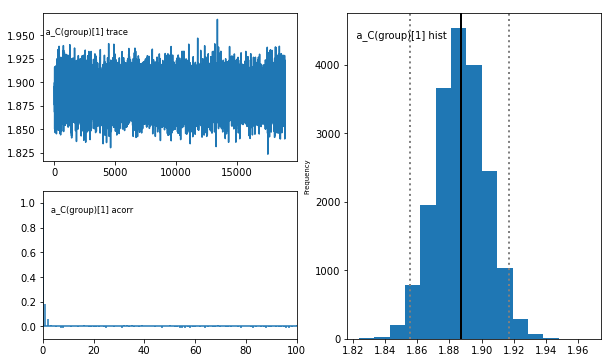

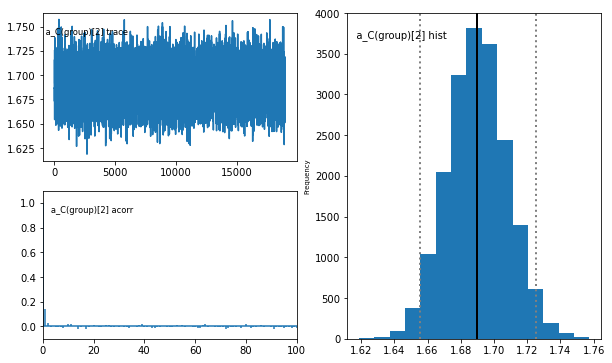

In [92]:
import os 
os.chdir('/home/jovyan/hddm/models/parallel') # directory 
#load previous combined model (or a different one)
m=hddm.load('combinedM')

stats = m.gen_stats()
m.print_stats()

m.plot_posteriors()
print('BPIC of combined model = {BPIC}'.format(BPIC=m.mc.BPIC))

### Plot the posterior distributions from the combined model 

P_v(pre-HD < Control) =  0.023105263157894736
P_v(pre-HD < early-HD) =  0.29873684210526313
P(HC > early-HD =  0.16521052631578947


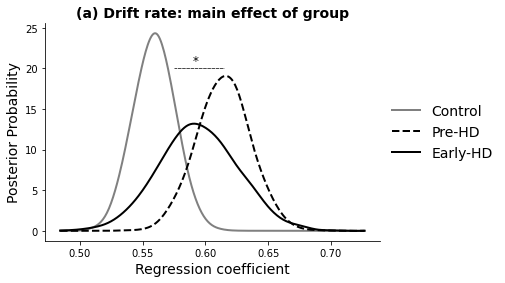

In [93]:
#drift rate: main effect of group 
# (n.b control group is set as the intercept in regression model since it is the reference group - see Patsy documentation):
# get data
vhc = m.nodes_db.node['v_C(group)[0]']
vpre = m.nodes_db.node['v_C(group)[1]']
vearly = m.nodes_db.node['v_C(group)[2]']
#plot 
hddm.analyze.plot_posterior_nodes([vhc, vpre, vearly], bins=20)
plt.xlabel('Regression coefficient', fontsize=14)
plt.ylabel('Posterior Probability', fontsize=14)
plt.title('(a) Drift rate: main effect of group', fontsize=14, fontweight='bold')

#set the colours and line style
for ax in plt.gcf().axes:
    ax.get_lines()[0].set_color("grey"); ax.get_lines()[1].set_color("black"); ax.get_lines()[2].set_color("black")
    ax.get_lines()[0].set_linestyle("-"); ax.get_lines()[1].set_linestyle("--"); ax.get_lines()[2].set_linestyle("-")

    
plt.legend(['Control', 'Pre-HD', 'Early-HD'], 
           loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#print probability that effect is in the opposite direction (equivalent to 1-sided t test):
#Probability mean pre-HD > mean HC:
print("P_v(pre-HD < Control) = ", (vpre.trace() < vhc.trace()).mean())
#Probability mean pre-HD > mean early-HD:
print("P_v(pre-HD < early-HD) = ", (vpre.trace() < vearly.trace()).mean())
#Probability mean for early-HD > mean HC:
print("P(HC > early-HD = ", (vhc.trace() > vearly.trace()).mean())

#manually plot asterisk and line
plt.plot((0.575, 0.615), (20,20), color='black', lw=0.7, linestyle=(1, (5, 1)))
plt.text(0.59, 20.5, "*", color='black', fontsize=12) #plot asterix in middle

#savefig:
plt.savefig('/home/jovyan/hddm/figs/supplementary_Figure3a.png', format='png', dpi=1200, 
            bbox_inches='tight',
           facecolor='white')   

P_v(pre-HD > HC (intercept)) =  0.0
P_v(pre-HD > early-HD) =  0.33631578947368423
P(early-HD > HC =  0.0


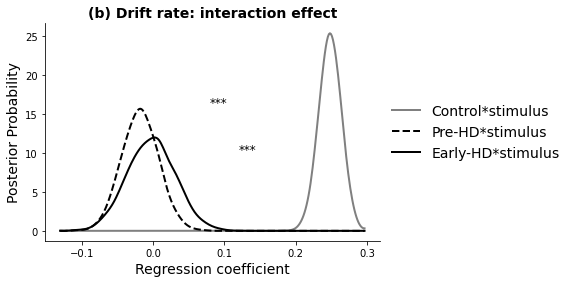

In [94]:
#plot drift rate: interaction effect group*stimulus strength (z-scored within individuals):
v_dd_pre = m.nodes_db.node['v_dd_Zws:C(group)[T.1]']
v_dd_early = m.nodes_db.node['v_dd_Zws:C(group)[T.2]']
v_dd_hc = m.nodes_db.node['v_dd_Zws']

hddm.analyze.plot_posterior_nodes([v_dd_hc, v_dd_pre, v_dd_early], bins=35)
plt.xlabel('Regression coefficient', fontsize=14)
plt.ylabel('Posterior Probability', fontsize=14)
plt.title('(b) Drift rate: interaction effect', fontsize=14, fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#set the colours and line style
for ax in plt.gcf().axes:
    ax.get_lines()[0].set_color("grey"); ax.get_lines()[1].set_color("black"); ax.get_lines()[2].set_color("black")
    ax.get_lines()[0].set_linestyle("-"); ax.get_lines()[1].set_linestyle("--"); ax.get_lines()[2].set_linestyle("-")
    
plt.legend(['Control*stimulus', 'Pre-HD*stimulus', 'Early-HD*stimulus'], 
           loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, frameon=False)

#print probability that effect is in the opposite direction
#Probability mean pre-HD > mean HC:
print("P_v(pre-HD > HC (intercept)) = ", (v_dd_pre.trace() > v_dd_hc.trace()).mean())
#Probability mean pre-HD > mean early-HD:
print("P_v(pre-HD > early-HD) = ", (v_dd_pre.trace() > v_dd_early.trace()).mean())
#Probability mean for early-HD > mean HC:
print("P(early-HD > HC = ", (v_dd_early.trace() > v_dd_hc.trace()).mean())

#manually plot difference asterisk 
plt.text(0.12, 10, "***", color='black', fontsize=12) 
plt.text(0.08, 16, "***", color='black', fontsize=12)

#save figure:
plt.savefig('/home/jovyan/hddm/figs/supplementary_Figure3b.png', format='png', dpi=1200, 
            bbox_inches='tight',
           facecolor='white')   

P_a(pre-HD > HC =  0.0
P_a(early-HD > pre-HD) =  0.0
P_a(early-HD > HC) =  0.0


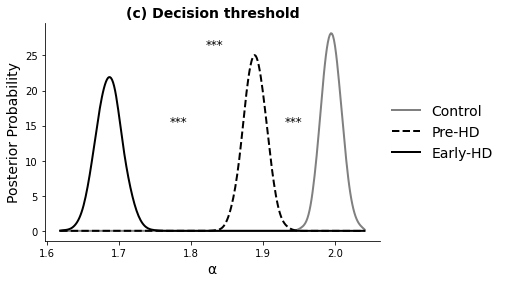

In [95]:
#plot main effect of group on alpha (decision boundary)
a_pre = m.nodes_db.node['a_C(group)[1]']
a_early = m.nodes_db.node['a_C(group)[2]']
a_hc = m.nodes_db.node['a_C(group)[0]']
hddm.analyze.plot_posterior_nodes([a_hc, a_pre, a_early], bins=40)
plt.ylabel('Posterior Probability', fontsize=14)
plt.xlabel('\u03B1', fontsize=14)
plt.title('(c) Decision threshold', fontsize=14, fontweight='bold')

#set the colours:
for ax in plt.gcf().axes:
    ax.get_lines()[0].set_color("grey"); ax.get_lines()[1].set_color("black"); ax.get_lines()[2].set_color("black")
    ax.get_lines()[0].set_linestyle("-"); ax.get_lines()[1].set_linestyle("--"); ax.get_lines()[2].set_linestyle("-")
    
plt.legend(['Control', 'Pre-HD', 'Early-HD'], 
           loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#print probability that effect is in the opposite direction
print("P_a(pre-HD > HC = ", (a_pre.trace() > a_hc.trace()).mean())
print("P_a(early-HD > pre-HD) = ", (a_early.trace() > a_pre.trace()).mean())
print("P_a(early-HD > HC) = ", (a_early.trace() > a_hc.trace()).mean())

# manually plot meaningful difference based on above probability 
plt.text(1.93, 15, "***", color='black', fontsize=12) #plot asterix 
plt.text(1.77, 15, "***", color='black', fontsize=12) #plot asterix
plt.text(1.82, 26, "***", color='black', fontsize=12) #plot asterix 


#savefig:
plt.savefig('/home/jovyan/hddm/figs/supplementary_Figure3c.png', format='png', dpi=1200, 
            bbox_inches='tight',
           facecolor='white')   

### run PPC to simulate rt data from model (must load model first ^^^^) 
### check model can reproduce behaviour of the groups 
##### patch to use PPC with HDDM regression, source: https://groups.google.com/g/hddm-users/c/0mUx9WMZXuw/m/Dh8l-kymAwAJ

In [130]:
import pymc as pm
import numpy as np
import pymc.progressbar as pbar

def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]

def _post_pred_generate(bottom_node, samples=500, data=None, append_data=True):
    """Generate posterior predictive data from a single observed node."""
    datasets = []
    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        if append_data and data is not None:
            sampled_data.reset_index(inplace=True)  # Only modification of original Kabuki code
            sampled_data = sampled_data.join(data.reset_index(), lsuffix='_sampled')
        datasets.append(sampled_data)
    return datasets

def post_pred_gen(model, groupby=None, samples=500, append_data=False, progress_bar=True):
    results = {}

    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        iter_data = ((name, model.data.iloc[obs['node'].value.index]) for name, obs in model.iter_observeds())

    else:
        iter_data = model.data.groupby(groupby)

    for name, data in iter_data:
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, 'random'):
            continue # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(node, samples=samples, data=data, append_data=append_data)
        results[name] = pd.concat(datasets, names=['sample'], keys=list(range(len(datasets))))

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    return pd.concat(results, names=['node'])

#simulate rt data from 1000 samples, to test groups (use group by on the resulting dataframe)
nsamples=500
ppc_data = post_pred_gen(combined_model2, samples=nsamples, append_data=True)
ppc_compare = hddm.utils.post_pred_stats(data, ppc_data)
#save the resultant df as .pkl file 
ppc_data.to_pickle("/home/jovyan/hddm/models/ppc/PPC_combinedM.pkl")
ppc_data_grouped = ppc_data.groupby('group').mean()
print(ppc_data) #print ppc data 
print(ppc_data_grouped) #print groupby ppc

 [-----------------105%------------------] 61 of 58 complete in 23070.3 sec

NameError: name 'dataAC' is not defined

## Alternatively load the previous PPC data  

In [19]:
#if not running PPC; load the pickle object:
ppc_data=pd.read_pickle('/home/jovyan/hddm/models/ppc/PPC_combinedM.pkl')

In [28]:
#compare to get statistics:
ppc_compareCCf = hddm.utils.post_pred_stats(data, ppc_data, call_compare=False)
ppc_compareCC = hddm.utils.post_pred_stats(data, ppc_data, call_compare=True)

#ppc_data_grouped = ppc_data.groupby('group').mean()
ppc_compareCC.head()

#reset 
ppc_compareCCf_reset=ppc_compareCCf.reset_index() #reset index to work with it more easily
ppc_compareCCf_reset["subj_idx"]=ppc_compareCCf_reset['node'].str.slice(start=5) #slice ID from node and add as new column
ppc_compareCCf_reset['subj_idx'] = ppc_compareCCf_reset['subj_idx'].astype(int)
ppc_compareCCf_subj=ppc_compareCCf_reset.groupby(["subj_idx"]).mean() #groupby subject means
ppc_compareCCf_subjMed=ppc_compareCCf_reset.groupby(["subj_idx"]).median() #groupby subject medians

#get subject id list from og data:
subjects=sorted(data.subj_idx.unique()) #sort IDs
subj_group=np.array([data.loc[data['subj_idx'] == i, 'group'].iloc[0] for i in sorted(subjects)]) #get group from subject as index
data_subj=data.groupby(['subj_idx', 'response']).mean()
data_subjMedian=data.groupby(['subj_idx', 'response']).median()

#add subj_group into PPC to then groupby:
ppc_compareCCf_subj["group"]=subj_group
ppc_compareCCf_group=ppc_compareCCf_subj.groupby(["group"]).mean() #groupby
ppc_compareCCf_groupStd=ppc_compareCCf_subj.groupby(["group"]).std() #groupby, summary=standard deviation

KeyboardInterrupt: 

In [21]:
#calculate quantile rts for observed AT GROUP LEVEL:
groups=[0, 1, 2]
quantiles=[.1, .3, .5, .7, .9]
#correct observed quantiles:
obs_rt10qCor=np.array([data.groupby(['group', 'response']).quantile(quantiles[0]).loc[(i,1), ('rt')] for i in groups])
obs_rt30qCor=np.array([data.groupby(['group', 'response']).quantile(quantiles[1]).loc[(i,1), ('rt')] for i in groups])
obs_rt50qCor=np.array([data.groupby(['group', 'response']).quantile(quantiles[2]).loc[(i,1), ('rt')] for i in groups])
obs_rt70qCor=np.array([data.groupby(['group', 'response']).quantile(quantiles[3]).loc[(i,1), ('rt')] for i in groups])
obs_rt90qCor=np.array([data.groupby(['group', 'response']).quantile(quantiles[4]).loc[(i,1), ('rt')] for i in groups])

#incorrect observed quantiles:
obs_rt10qInc=np.array([data.groupby(['group', 'response']).quantile(quantiles[0]).loc[(i,0), ('rt')] for i in groups])
obs_rt30qInc=np.array([data.groupby(['group', 'response']).quantile(quantiles[1]).loc[(i,0), ('rt')] for i in groups])
obs_rt50qInc=np.array([data.groupby(['group', 'response']).quantile(quantiles[2]).loc[(i,0), ('rt')] for i in groups])
obs_rt70qInc=np.array([data.groupby(['group', 'response']).quantile(quantiles[3]).loc[(i,0), ('rt')] for i in groups])
obs_rt90qInc=np.array([data.groupby(['group', 'response']).quantile(quantiles[4]).loc[(i,0), ('rt')] for i in groups])

#correct PPC quantiles:
ppc_rt10qCor=np.abs([ppc_compareCCf_group.loc[i, '10q_ub'] for i in groups])
ppc_rt30qCor=np.abs([ppc_compareCCf_group.loc[i, '30q_ub'] for i in groups])
ppc_rt50qCor=np.abs([ppc_compareCCf_group.loc[i, '50q_ub'] for i in groups])
ppc_rt70qCor=np.abs([ppc_compareCCf_group.loc[i, '70q_ub'] for i in groups])
ppc_rt90qCor=np.abs([ppc_compareCCf_group.loc[i, '90q_ub'] for i in groups])
#incorrect PPC quantiles
ppc_rt10qInc=np.abs([ppc_compareCCf_group.loc[i, '10q_lb'] for i in groups])
ppc_rt30qInc=np.abs([ppc_compareCCf_group.loc[i, '30q_lb'] for i in groups])
ppc_rt50qInc=np.abs([ppc_compareCCf_group.loc[i, '50q_lb'] for i in groups])
ppc_rt70qInc=np.abs([ppc_compareCCf_group.loc[i, '70q_lb'] for i in groups])
ppc_rt90qInc=np.abs([ppc_compareCCf_group.loc[i, '90q_lb'] for i in groups])

#get quantiles without groups: 
obs_rtCor=np.array([data.groupby(['response']).quantile(quantiles[i]).loc[(1), ('rt')] for i in range(len(quantiles))])
obs_rtInc=np.array([data.groupby(['response']).quantile(quantiles[i]).loc[(0), ('rt')] for i in range(len(quantiles))])
obs_rtCorStd=np.array(data.groupby(['response']).agg(['quantile', 'std']))
obs_rtCorCorQ=np.array(data.groupby(['response']).agg(['quantile', 'mean']))
ppc_rtCor=np.array([data.groupby(['response']).quantile(quantiles[i]).loc[(1), ('rt')] for i in range(len(quantiles))])

quants=["10q", "30q", "50q", "70q", "90q"]
ppc_rtInc=np.array([ppc_compareCCf[i + "_lb"].mean() for i in quants])
ppc_rtIncStd=np.array([ppc_compareCCf[i + "_lb"].std() for i in quants])
ppc_rtCor=np.array([ppc_compareCCf[i + "_ub"].mean() for i in quants])
ppc_rtCorStd=np.array([ppc_compareCCf[i + "_ub"].std() for i in quants])

#standard deviation for groups, use to plot:
#correct (UB)
ppc_rt10qCorStd=np.abs([ppc_compareCCf_groupStd.loc[i, '10q_ub'] for i in groups])
ppc_rt30qCorStd=np.abs([ppc_compareCCf_groupStd.loc[i, '30q_ub'] for i in groups])
ppc_rt50qCorStd=np.abs([ppc_compareCCf_groupStd.loc[i, '50q_ub'] for i in groups])
ppc_rt70qCorStd=np.abs([ppc_compareCCf_groupStd.loc[i, '70q_ub'] for i in groups])
ppc_rt90qCorStd=np.abs([ppc_compareCCf_groupStd.loc[i, '90q_ub'] for i in groups])
#incorrect (LB)
ppc_rt10qIncStd=np.abs([ppc_compareCCf_groupStd.loc[i, '10q_lb'] for i in groups])
ppc_rt30qIncStd=np.abs([ppc_compareCCf_groupStd.loc[i, '30q_lb'] for i in groups])
ppc_rt50qIncStd=np.abs([ppc_compareCCf_groupStd.loc[i, '50q_lb'] for i in groups])
ppc_rt70qIncStd=np.abs([ppc_compareCCf_groupStd.loc[i, '70q_lb'] for i in groups])
ppc_rt90qIncStd=np.abs([ppc_compareCCf_groupStd.loc[i, '90q_lb'] for i in groups])


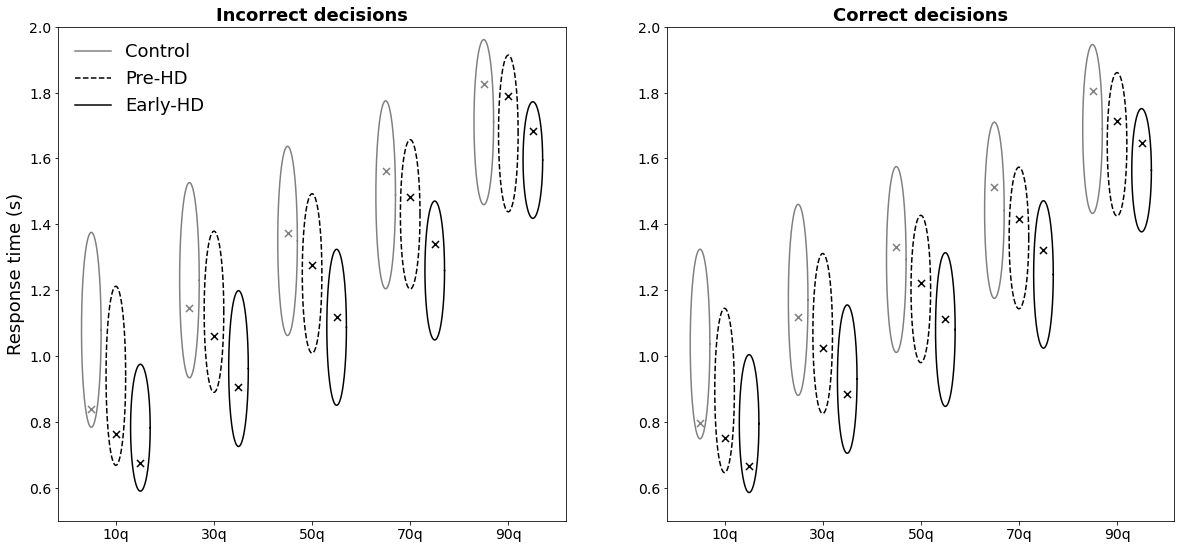

In [24]:
#plot each group seperately:
def Define_Ellipse(x_mean, y_mean, x_r, y_r, color, ls):
    Angles=np.pi*np.linspace(start=0,stop=2,num=360)
    x=x_mean+(x_r*np.cos(Angles))
    y=y_mean+(y_r*np.sin(Angles))
    return plt.plot(x,y, c=color, linestyle=ls)

x1=np.array([0, 1, 2, 3, 4])
#initialise lists:
obs_rtInc=[]; obs_rtCor=[]; ppc_rtInc=[]; ppc_rtCor=[]; ppc_rtIncStd=[]; ppc_rtCorStd=[];

for i in groups: 
    obs_rtInc.append(np.array([obs_rt10qInc[i], obs_rt30qInc[i], obs_rt50qInc[i], obs_rt70qInc[i], obs_rt90qInc[i]]))
    
    ppc_rtInc.append(np.array([ppc_rt10qInc[i], ppc_rt30qInc[i], ppc_rt50qInc[i], ppc_rt70qInc[i], ppc_rt90qInc[i]]))
    ppc_rtIncStd.append(np.array([ppc_rt10qIncStd[i], ppc_rt30qIncStd[i], ppc_rt50qIncStd[i],
                                  ppc_rt70qIncStd[i], ppc_rt90qIncStd[i]]))
    obs_rtCor.append(np.array([obs_rt10qCor[i], obs_rt30qCor[i], obs_rt50qCor[i], obs_rt70qCor[i], obs_rt90qCor[i]]))
    
    ppc_rtCor.append(np.array([ppc_rt10qCor[i], ppc_rt30qCor[i], ppc_rt50qCor[i], ppc_rt70qCor[i], ppc_rt90qCor[i]]))
    ppc_rtCorStd.append(np.array([ppc_rt10qCorStd[i], ppc_rt30qCorStd[i], ppc_rt50qCorStd[i],
                                  ppc_rt70qCorStd[i], ppc_rt90qCorStd[i]]))


fig=plt.figure(figsize=(20,20), facecolor='white')
ax1=fig.add_subplot(221)
plt.ylim([0.5, 2]); plt.yticks(fontsize=14)
plt.title('Incorrect decisions', fontweight='bold', fontsize=18)
plt.xticks(x1, quants, fontsize=14)
plt.ylabel('Response time (s)', fontsize=18)
plt.legend(['Control', 'Pre-HD', 'Early-HD'], 
           loc='upper left', fontsize=14, frameon=False)

for i in x1:
    ax1.scatter(x1[i]-0.25, obs_rtInc[0][i], 50, marker='x',color='grey', zorder=2);
    Define_Ellipse(x1[i]-0.25, ppc_rtInc[0][i], 0.1, ppc_rtIncStd[0][i], 'grey', '-')
    ax1.scatter(x1[i], obs_rtInc[1][i], 50, marker='x',color='black', zorder=2);
    Define_Ellipse(x1[i], ppc_rtInc[1][i], 0.1, ppc_rtIncStd[1][i], 'black', '--')
    ax1.scatter(x1[i]+0.25, obs_rtInc[2][i], 50, marker='x',color='black', zorder=2);
    Define_Ellipse(x1[i]+0.25, ppc_rtInc[2][i], 0.1, ppc_rtIncStd[2][i], 'black', '-')
plt.legend(['Control', 'Pre-HD', 'Early-HD'], 
           loc='upper left', fontsize=18, frameon=False)

ax2=fig.add_subplot(222, sharey=ax1)
plt.title('Correct decisions', fontweight='bold', fontsize=18)
plt.xticks(x1, quants, fontsize=14); plt.yticks(fontsize=14)
plt.legend(['Control', 'Pre-HD', 'Early-HD'], 
           loc='upper left', fontsize=14, frameon=False)

for i in x1:
    ax2.scatter(x1[i]-0.25, obs_rtCor[0][i], 50, marker='x',color='grey', zorder=2, label='HC');
    Define_Ellipse(x1[i]-0.25, ppc_rtCor[0][i], 0.1, ppc_rtCorStd[0][i], 'grey', '-')
    ax2.scatter(x1[i], obs_rtCor[1][i], 50, marker='x',color='black', zorder=2);
    Define_Ellipse(x1[i], ppc_rtCor[1][i], 0.1, ppc_rtCorStd[1][i], 'black', '--')
    ax2.scatter(x1[i]+0.25, obs_rtCor[2][i], 50, marker='x',color='black', zorder=2);
    Define_Ellipse(x1[i]+0.25, ppc_rtCor[2][i], 0.1, ppc_rtCorStd[2][i], 'black', '-')


#save figure
plt.savefig('/home/jovyan/hddm/figs/supplementary_figure2.png', format='png', dpi=1200, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor()) 